# ERA5 850 hPa Temperature (Zarr v3 on GCS) — Xarray Intro

This notebook introduces **xarray** concepts using **ERA5 hourly temperature on pressure levels** from Google Cloud (ARCO ERA5, Zarr v3). We will:
- Open a **Zarr v3** store with anonymous GCS access
- Select **850 hPa** and convert Kelvin → °C
- Pick a month to keep things lightweight
- Subset a geographic region
- Compute area-weighted time series and simple variability
- Make maps of month-mean, std, and range

**Deliverables:** Answer the **🧩 Questions** inline and complete the TODOs.


## 0) Setup

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask

plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['figure.dpi'] = 120

print('xarray', xr.__version__)


xarray 2025.9.0


In [2]:
from dask.distributed import Client
client = Client()  # set up local cluster on your machine
client

/Users/kheimes2/opt/anaconda3/envs/xarray-climate/lib/python3.13/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 60205 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:60205/status,
Dashboard: http://127.0.0.1:60205/status,Workers: 4
Total threads: 8,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:60206,Workers: 0
Dashboard: http://127.0.0.1:60205/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:60218,Total threads: 2
Dashboard: http://127.0.0.1:60222/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:60209,


## 1) Open ARCO ERA5 (Zarr v3) on Google Cloud

We will open the **ARCO ERA5** store and then constrain to a single month (hourly data) to make the exercise fast.

**🧩 Questions**
1. Why do we pass `storage_options={'token': 'anon'}`? since accessing public data, don’t need to enter credentials to access data
2. What is Zarr **v3** and how is it different from v2 for cloud data?
3. After opening, what are the coordinates and units for temperature? 
(time, level, latitude, longitude) in Kelvin



In [3]:
import gcsfs
fs = gcsfs.GCSFileSystem(token="anon")
# Should list arrays/metadata keys under the store
print(fs.ls("gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3")[:10])

['gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/.zattrs', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/.zgroup', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/.zmetadata', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/100m_u_component_of_wind', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/100m_v_component_of_wind', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_u_component_of_neutral_wind', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_u_component_of_wind', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_v_component_of_neutral_wind', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_v_component_of_wind', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_wind_gust_since_previous_post_processing']


In [19]:
# for HW: total_precipitation = large scale precipitation + convective precipitation (at surface level)

ds = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks=None,
    storage_options=dict(token='anon'),
)
ds = ds.sel(time=slice(ds.attrs['valid_time_start'], ds.attrs['valid_time_stop']))

ds

<xarray.Dataset> Size: 2PB
Dimensions:                                                          (
                                                                      time: 748008,
                                                                      latitude: 721,
                                                                      longitude: 1440,
                                                                      level: 37)
Coordinates:
  * latitude                                                         (latitude) float32 3kB ...
  * level                                                            (level) int64 296B ...
  * longitude                                                        (longitude) float32 6kB ...
  * time                                                             (time) datetime64[ns] 6MB ...
Data variables: (12/273)
    100m_u_component_of_wind                                         (time, latitude, longitude) float32 3TB ...
    100m_v_component_of_wind                                         (time, latitude, longitude) float32 3TB ...
    10m_u_component_of_neutral_wind                                  (time, latitude, longitude) float32 3TB ...
    10m_u_component_of_wind                                          (time, latitude, longitude) float32 3TB ...
    10m_v_component_of_neutral_wind                                  (time, latitude, longitude) float32 3TB ...
    10m_v_component_of_wind                                          (time, latitude, longitude) float32 3TB ...
    ...                                                               ...
    wave_spectral_directional_width_for_swell                        (time, latitude, longitude) float32 3TB ...
    wave_spectral_directional_width_for_wind_waves                   (time, latitude, longitude) float32 3TB ...
    wave_spectral_kurtosis                                           (time, latitude, longitude) float32 3TB ...
    wave_spectral_peakedness                                         (time, latitude, longitude) float32 3TB ...
    wave_spectral_skewness                                           (time, latitude, longitude) float32 3TB ...
    zero_degree_level                                                (time, latitude, longitude) float32 3TB ...
Attributes:
    last_updated:           2025-09-17 01:52:42.420936+00:00
    valid_time_start:       1940-01-01
    valid_time_stop:        2025-04-30
    valid_time_stop_era5t:  2025-09-11

## 2) Select variable/level and a single month

We'll select **temperature (`temperature`) at 850 hPa**, convert to **°C**, and then restrict to one calendar month to keep computations light.

**🧩 Questions**
1. Which dimension name does this store use for pressure levels (`isobaricInhPa`, `level`, or something else)? Level
2. What is the native unit of `temperature`? Kelvin


In [20]:
# Pick a month (YYYY-MM) for the exercise
month = "2020-01"   # TODO: change to another month if desired
t0 = pd.to_datetime(month + "-01")
t1 = (t0 + pd.offsets.MonthEnd(1)).strftime("%Y-%m-%d")

var = 'temperature'

dss=ds.sel(time=slice('2020-02-01 00:00','2020-02-29 23:59'), level=850)
dss

<xarray.Dataset> Size: 789GB
Dimensions:                                                          (
                                                                      time: 696,
                                                                      latitude: 721,
                                                                      longitude: 1440)
Coordinates:
  * latitude                                                         (latitude) float32 3kB ...
    level                                                            int64 8B ...
  * longitude                                                        (longitude) float32 6kB ...
  * time                                                             (time) datetime64[ns] 6kB ...
Data variables: (12/273)
    100m_u_component_of_wind                                         (time, latitude, longitude) float32 3GB ...
    100m_v_component_of_wind                                         (time, latitude, longitude) float32 3GB ...
    10m_u_component_of_neutral_wind                                  (time, latitude, longitude) float32 3GB ...
    10m_u_component_of_wind                                          (time, latitude, longitude) float32 3GB ...
    10m_v_component_of_neutral_wind                                  (time, latitude, longitude) float32 3GB ...
    10m_v_component_of_wind                                          (time, latitude, longitude) float32 3GB ...
    ...                                                               ...
    wave_spectral_directional_width_for_swell                        (time, latitude, longitude) float32 3GB ...
    wave_spectral_directional_width_for_wind_waves                   (time, latitude, longitude) float32 3GB ...
    wave_spectral_kurtosis                                           (time, latitude, longitude) float32 3GB ...
    wave_spectral_peakedness                                         (time, latitude, longitude) float32 3GB ...
    wave_spectral_skewness                                           (time, latitude, longitude) float32 3GB ...
    zero_degree_level                                                (time, latitude, longitude) float32 3GB ...
Attributes:
    last_updated:           2025-09-17 01:52:42.420936+00:00
    valid_time_start:       1940-01-01
    valid_time_stop:        2025-04-30
    valid_time_stop_era5t:  2025-09-11

## 3) Explore coordinates & variables

**🧩 Questions**
1. What are the dimensions of `t850` (order and sizes)? Lat/long/time
2. What is the longitude convention (0–360 or −180–180)? degrees east
3. Are there any missing values in your month? How are they represented?


In [21]:
list(dss.data_vars), list(dss.coords), dss[var]

(['100m_u_component_of_wind',
  '100m_v_component_of_wind',
  '10m_u_component_of_neutral_wind',
  '10m_u_component_of_wind',
  '10m_v_component_of_neutral_wind',
  '10m_v_component_of_wind',
  '10m_wind_gust_since_previous_post_processing',
  '2m_dewpoint_temperature',
  '2m_temperature',
  'air_density_over_the_oceans',
  'angle_of_sub_gridscale_orography',
  'anisotropy_of_sub_gridscale_orography',
  'benjamin_feir_index',
  'boundary_layer_dissipation',
  'boundary_layer_height',
  'charnock',
  'clear_sky_direct_solar_radiation_at_surface',
  'cloud_base_height',
  'coefficient_of_drag_with_waves',
  'convective_available_potential_energy',
  'convective_inhibition',
  'convective_precipitation',
  'convective_rain_rate',
  'convective_snowfall',
  'convective_snowfall_rate_water_equivalent',
  'downward_uv_radiation_at_the_surface',
  'duct_base_height',
  'eastward_gravity_wave_surface_stress',
  'eastward_turbulent_surface_stress',
  'evaporation',
  'forecast_albedo',
  'forec

## 4) Region subsetting

Choose a geographic box (edit as desired):
- **Central U.S.:** lon −110 to −80, lat 25 to 45
- **Europe:** lon −10 to 30, lat 35 to 60
- **Argentina:** lon −75 to −55, lat −40 to −20

**🧩 Questions**
1. Why might we need to convert longitudes from [-180,180] to [0,360]?
2. How many grid points (lat×lon) and time steps are in your subset?


In [22]:
dsss = dss[var].sel(latitude=slice(45,25), longitude=slice(-110+360, -80+360))
dsss

<xarray.DataArray 'temperature' (time: 696, latitude: 81, longitude: 121)> Size: 27MB
[6821496 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 324B 45.0 44.75 44.5 44.25 ... 25.5 25.25 25.0
    level      int64 8B 850
  * longitude  (longitude) float32 484B 250.0 250.2 250.5 ... 279.5 279.8 280.0
  * time       (time) datetime64[ns] 6kB 2020-02-01 ... 2020-02-29T23:00:00
Attributes:
    long_name:      Temperature
    short_name:     t
    standard_name:  air_temperature
    units:          K

## 5) Area-weighted region-mean (hourly) and daily mean

Compute an **area-weighted** (cos(lat)) region-mean time series. Then, compute a **daily mean** series from the hourly data.


In [25]:
import cartopy.crs as ccrs

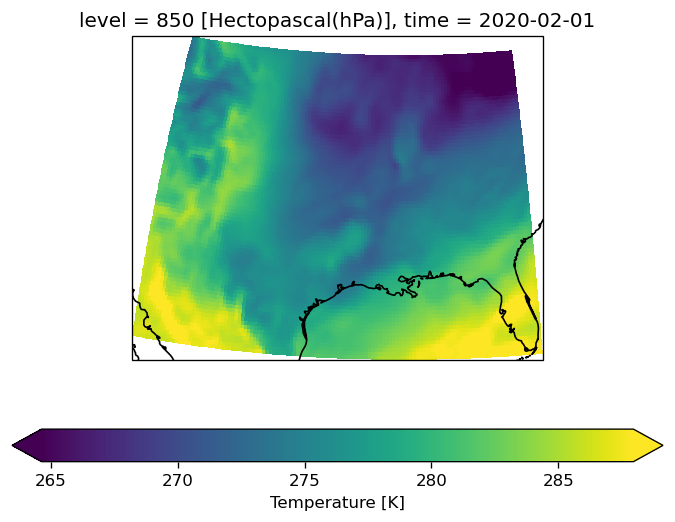

In [26]:
fig, axis = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Orthographic(-90, 30)))
dsss.isel(time=0).plot(ax=axis,
    transform=ccrs.PlateCarree(),  # this is important!
    # usual xarray stuff
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.7},
    robust=True,)
axis.coastlines()

## 8) Export a small deliverable (optional)

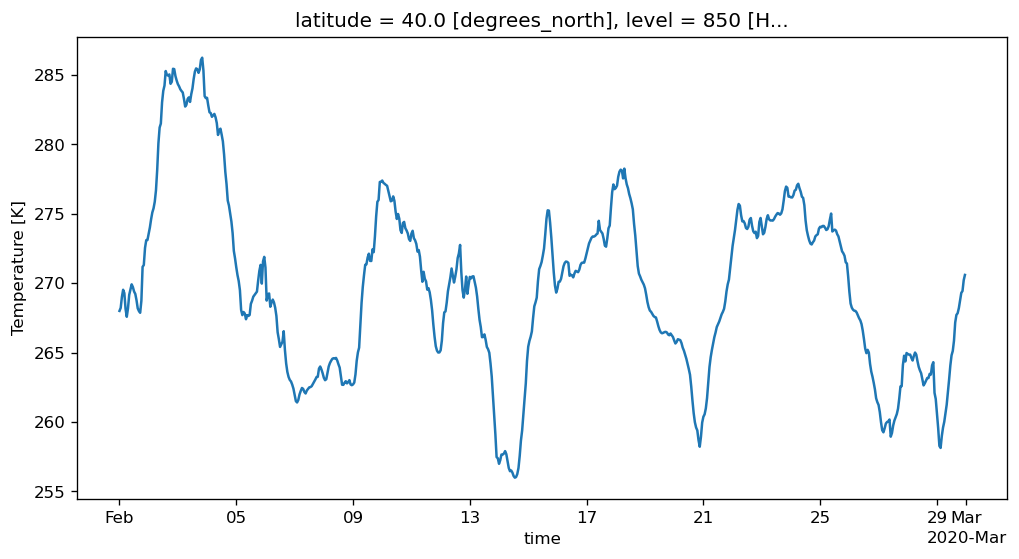

In [27]:
# Temp time series over champaign of 850 mb temperature over the whole month
dsss.sel(latitude=40, longitude=-88+360).plot()

In [29]:
client.close()